<a href="https://colab.research.google.com/github/ameyarsalvi/Autonomous_Vehicle/blob/master/BehaviourCloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/ameyarsalvi/Autonomous_Vehicle.git

Cloning into 'Autonomous_Vehicle'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17565 (delta 1), reused 13 (delta 1), pack-reused 17552
Receiving objects: 100% (17565/17565), 283.35 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (18192/18192), done.


In [3]:
ls Autonomous_Vehicle/


 Data/     'Finding Lanes'/        'Python Exercises'/
 Driving/  'Logistic Regression'/   README.md


In [4]:
ls Autonomous_Vehicle/Data/

driving_log.csv  IMG/


In [5]:
!pip3 install imgaug


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D,MaxPooling2D,Dropout, Flatten
from keras.optimizers import Adam
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [7]:
datadir='Autonomous_Vehicle/Data'
columns=['Center','Left','Right','Steering','Throttle','Reverse','Speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


Center  ...     Speed
0  C:\Users\ameya\Desktop\New folder\IMG\center_2020_06_09_08_56_46_196.jpg  ...  0.000079
1  C:\Users\ameya\Desktop\New folder\IMG\center_2020_06_09_08_56_46_395.jpg  ...  0.000080
2  C:\Users\ameya\Desktop\New folder\IMG\center_2020_06_09_08_56_46_511.jpg  ...  0.000079
3  C:\Users\ameya\Desktop\New folder\IMG\center_2020_06_09_08_56_46_639.jpg  ...  0.000080
4  C:\Users\ameya\Desktop\New folder\IMG\center_2020_06_09_08_56_46_750.jpg  ...  0.000078

[5 rows x 7 columns]

In [8]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail

data['Center']=data['Center'].apply(path_leaf)
data['Left']=data['Left'].apply(path_leaf)
data['Right']=data['Right'].apply(path_leaf)
data.head()

Center  ...     Speed
0  center_2020_06_09_08_56_46_196.jpg  ...  0.000079
1  center_2020_06_09_08_56_46_395.jpg  ...  0.000080
2  center_2020_06_09_08_56_46_511.jpg  ...  0.000079
3  center_2020_06_09_08_56_46_639.jpg  ...  0.000080
4  center_2020_06_09_08_56_46_750.jpg  ...  0.000078

[5 rows x 7 columns]

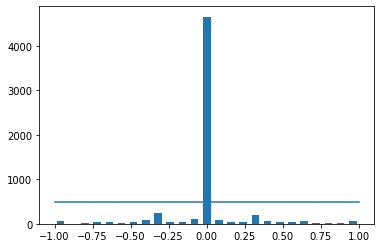

In [9]:
num_bins=25
samples_per_bin=500
hist,bins=np.histogram(data['Steering'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['Steering']),np.max(data['Steering'])),(samples_per_bin,samples_per_bin))

total data 6059
removed 4160
remaining 1899


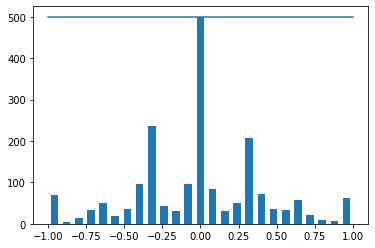

In [10]:
print('total data',len(data))
remove_list=[]

for j in range(num_bins):
  list_=[]
  for i in range(len(data['Steering'])):
    if data['Steering'][i]>=bins[j] and data['Steering'][i]<=bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining',len(data))

hist,_=np.histogram(data['Steering'],num_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['Steering']),np.max(data['Steering'])),(samples_per_bin,samples_per_bin))

In [11]:
print(data.iloc[1])

def load_image_steering(datadir,df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings

image_paths,steerings=load_image_steering(datadir+'/IMG',data)


Center      center_2020_06_09_08_56_47_216.jpg
Left        left_2020_06_09_08_56_47_216.jpg  
Right       right_2020_06_09_08_56_47_216.jpg 
Steering    0                                 
Throttle    0                                 
Reverse     0                                 
Speed       7.83315e-05                       
Name: 8, dtype: object


In [12]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=5)
print('Training Samples:{}\nValidation Samples:{}'.format(len(X_train),len(X_valid)))

Training Samples:1519
Validation Samples:380


Text(0.5, 1.0, 'Validation Set')

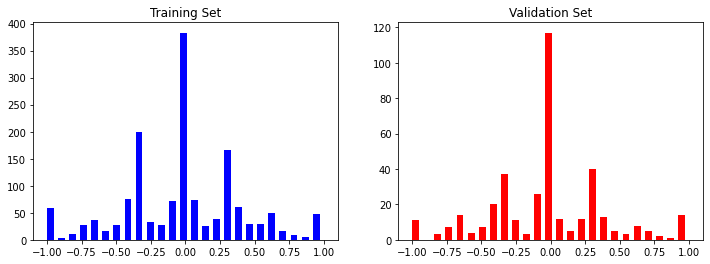

In [13]:
fig,axs=plt.subplots(1,2,figsize=(12,4))
axs[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axs[0].set_title('Training Set')
axs[1].hist(y_valid,bins=num_bins,width=0.05,color='red')
axs[1].set_title('Validation Set')

In [0]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed image')

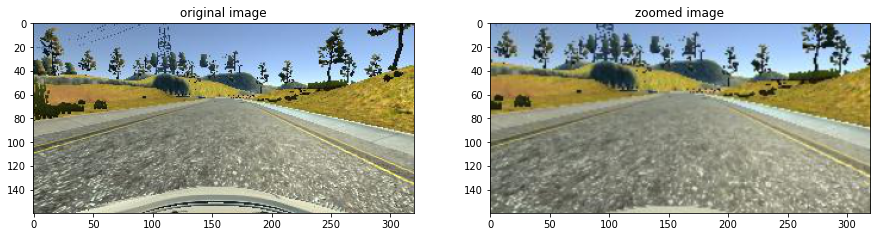

In [15]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed image')

In [0]:
def pan(image):
  pan=iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image=pan.augment_image(image)
  return image

Text(0.5, 1.0, 'panned image')

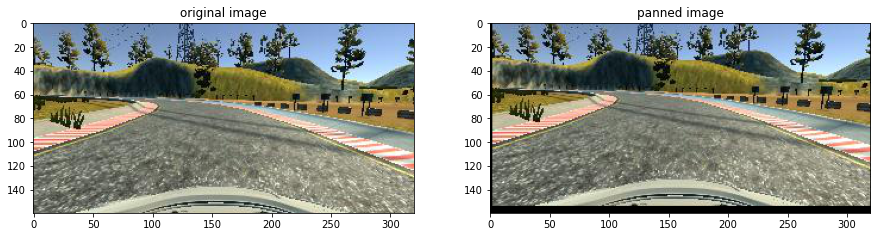

In [17]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
panned_image=pan(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(panned_image)
axs[1].set_title('panned image')

In [0]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2,1.2))
  image=brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'brightnes_altered image')

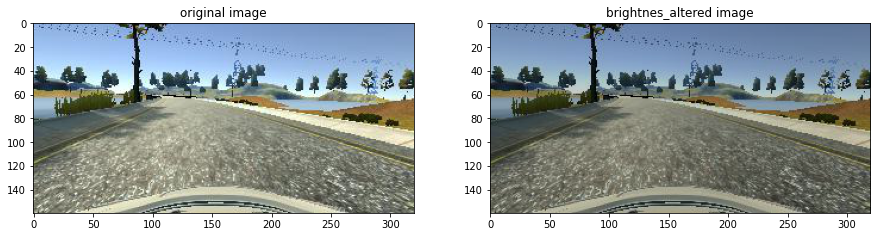

In [19]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
brightness_alt_img=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(brightness_alt_img)
axs[1].set_title('brightnes_altered image')

In [0]:
def img_flip(image,steering_angle):
  image=cv2.flip(image,1)
  steering_angle=-steering_angle
  return image,steering_angle

Text(0.5, 1.0, 'brightnes_altered image-altered steering angle:0.028010400000000005')

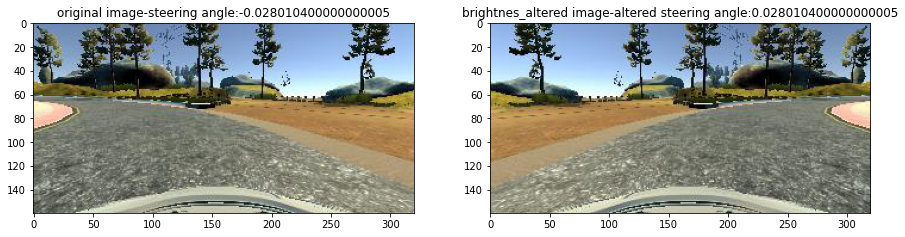

In [21]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]

original_image=mpimg.imread(image)
flipped_image,flipped_steer_angle=img_flip(original_image,steering_angle)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout
axs[0].imshow(original_image)
axs[0].set_title('original image-'+'steering angle:'+str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('brightnes_altered image-'+'altered steering angle:'+str(flipped_steer_angle))

In [0]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand()<0.5:
    image=img_random_brightness(image)
  if np.random.rand()<0.5:
    image,steering_angle=img_flip(image,steering_angle)
  
  return image, steering_angle
  
  

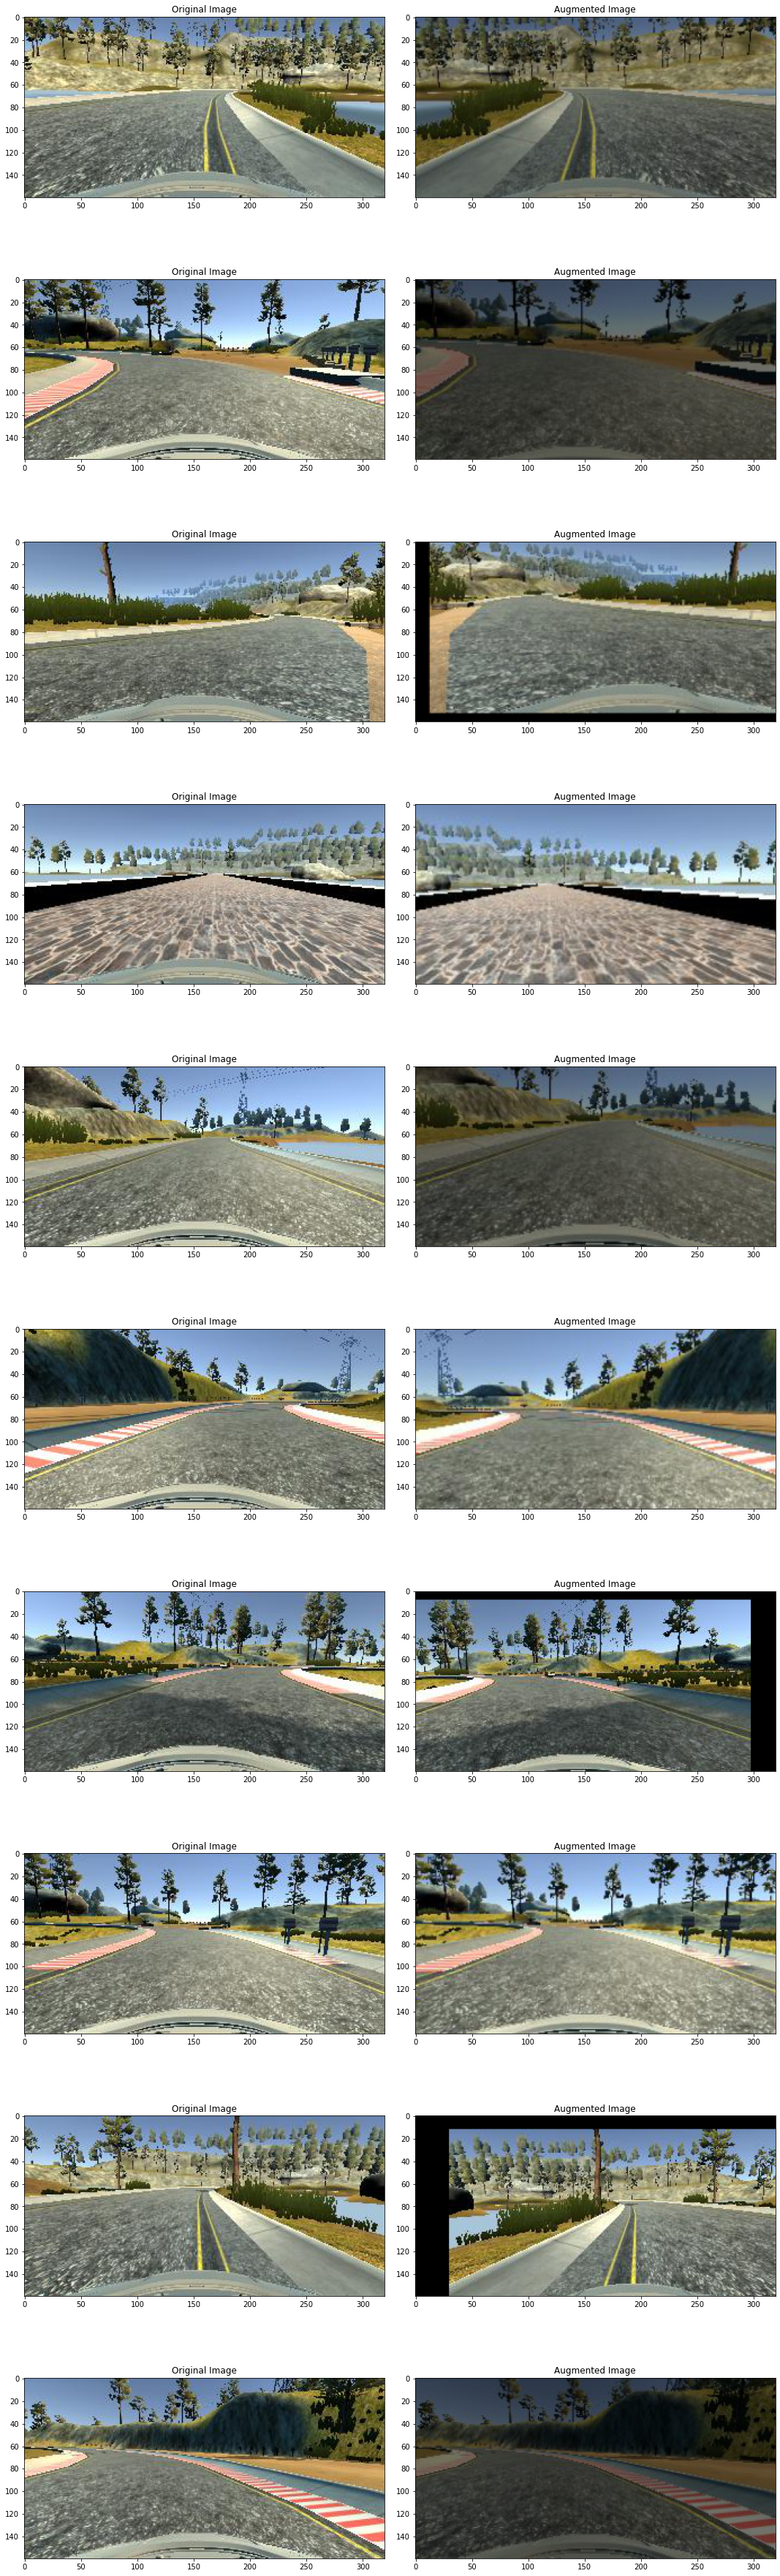

In [23]:
ncols=2
nrows=10

fig,axs=plt.subplots(nrows,ncols,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum=random.randint(0,len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]

  original_image=mpimg.imread(random_image)
  augmented_image,steering=random_augment(random_image,random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [0]:
def img_preprocess(img):
  img=img[60:135,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img, (3,3), 0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

In [0]:
def batch_generator(image_paths,steering_ang,batch_size,istraining):
  while True:
    batch_img=[]
    batch_steering=[]
    for i in range(batch_size):
      random_index=random.randint(0,len(image_paths)-1)
      if istraining:
        im,steering=random_augment(image_paths[random_index],steering_ang[random_index])
      else:
        im=mpimg.imread(image_paths[random_index])
        steering=steering_ang[random_index]
      im=img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield(np.asarray(batch_img),np.asarray(batch_steering))
      

Text(0.5, 1.0, 'Validation image')

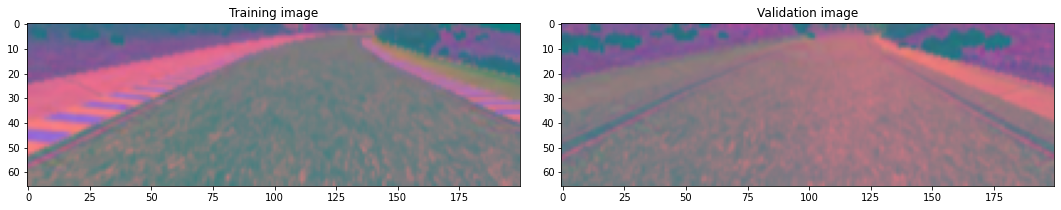

In [26]:
x_train_gen,y_train_gen=next(batch_generator(X_train,y_train,1,1))
x_val_gen,y_val_gen=next(batch_generator(X_valid,y_valid,1,0))


fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training image')
axs[1].imshow(x_val_gen[0])
axs[1].set_title('Validation image')


In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,5,5, subsample=(2,2), input_shape=(66,200,3),activation='elu'))
  model.add(Convolution2D(36,5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48,5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64,3,3, activation='elu'))

  model.add(Convolution2D(64,3,3, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer= Adam(lr=1e-5)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [28]:
model=nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  


In [29]:
h=model.fit_generator(batch_generator(X_train,y_train,100,1),
                      steps_per_epoch=600,
                      epochs=30,
                      validation_data=batch_generator(X_valid,y_valid,100,0),
                      validation_steps=250,
                      verbose=1,
                      shuffle=1)


Epoch 1/30
600/600 [==============================] - 410s 684ms/step - loss: 0.2287 - val_loss: 0.1594
Epoch 2/30
600/600 [==============================] - 401s 668ms/step - loss: 0.1706 - val_loss: 0.1595
Epoch 3/30
600/600 [==============================] - 398s 664ms/step - loss: 0.1595 - val_loss: 0.1146
Epoch 4/30
600/600 [==============================] - 407s 679ms/step - loss: 0.1564 - val_loss: 0.1158
Epoch 5/30
600/600 [==============================] - 400s 667ms/step - loss: 0.1549 - val_loss: 0.1141
Epoch 6/30
600/600 [==============================] - 403s 671ms/step - loss: 0.1519 - val_loss: 0.1262
Epoch 7/30
600/600 [==============================] - 407s 678ms/step - loss: 0.1517 - val_loss: 0.1158
Epoch 8/30
600/600 [==============================] - 399s 665ms/step - loss: 0.1485 - val_loss: 0.1177
Epoch 9/30
600/600 [==============================] - 401s 669ms/step - loss: 0.1493 - val_loss: 0.0999
Epoch 10/30
600/600 [==============================] - 413s 688m

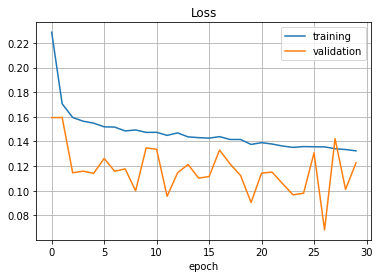

In [30]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.grid('on')


In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')
